In [132]:
import os
import shutil

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
!ls tmp/market_1501_metric_learning

bounding_box_train test.csv           train.csv


In [3]:
im_dir = 'tmp/market_1501_metric_learning/bounding_box_train'

In [4]:
d_train = pd.read_csv('tmp/market_1501_metric_learning/train.csv', dtype = {'label':'object'})
d_test = pd.read_csv('tmp/market_1501_metric_learning/test.csv', dtype = {'label':'object'})
d_train.shape, d_test.shape

((12936, 3), (534, 3))

In [7]:
d_train

,image_id,label,fold
0,0517_c5s1_143520_02.jpg,0517,4
1,0816_c6s2_104418_01.jpg,0816,6
2,1278_c1s6_012016_02.jpg,1278,7
3,0508_c5s2_082302_02.jpg,0508,1
4,1198_c6s3_034292_01.jpg,1198,8
...,...,...,...
12931,1454_c5s3_058740_07.jpg,1454,3
12932,1479_c6s3_084617_02.jpg,1479,5
12933,0208_c2s1_045276_03.jpg,0208,1
12934,0726_c6s2_075643_01.jpg,0726,4


In [8]:
d_test

,image_id,label,fold
0,0111_c5s1_019051_04.jpg,0111,0
1,0340_c5s1_080648_05.jpg,0340,0
2,0641_c1s3_044426_01.jpg,0641,0
3,0279_c3s1_154833_03.jpg,0279,0
4,1368_c1s5_069791_04.jpg,1368,0
...,...,...,...
529,0484_c5s1_126720_01.jpg,0484,0
530,0832_c2s3_063427_14.jpg,0832,0
531,1078_c4s5_008004_01.jpg,1078,0
532,0427_c3s1_104367_04.jpg,0427,0


In [10]:
d_train['source'] = 'train'
d_test['source'] = 'test'

d = pd.concat([d_train, d_test])
d.shape

(13470, 4)

In [11]:
d

,image_id,label,fold,source
0,0517_c5s1_143520_02.jpg,0517,4,train
1,0816_c6s2_104418_01.jpg,0816,6,train
2,1278_c1s6_012016_02.jpg,1278,7,train
3,0508_c5s2_082302_02.jpg,0508,1,train
4,1198_c6s3_034292_01.jpg,1198,8,train
...,...,...,...,...
529,0484_c5s1_126720_01.jpg,0484,0,test
530,0832_c2s3_063427_14.jpg,0832,0,test
531,1078_c4s5_008004_01.jpg,1078,0,test
532,0427_c3s1_104367_04.jpg,0427,0,test


In [18]:
d_dist = pd.DataFrame(d['label'].value_counts()).reset_index()
d_dist.columns = ['label', 'n']
d_dist

,label,n
0,0299,81
1,0139,72
2,0105,70
3,0272,67
4,0208,63
...,...,...
746,0323,3
747,0169,3
748,0389,3
749,0129,2


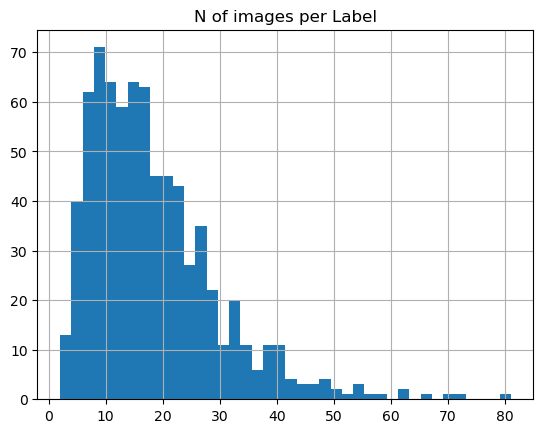

In [24]:
d_dist['n'].hist(bins=40)
plt.title('N of images per Label')
plt.show()

In [26]:
d_dist['n'].describe()

count    751.000000
mean      17.936085
std       11.327779
min        2.000000
25%       10.000000
50%       16.000000
75%       23.000000
max       81.000000
Name: n, dtype: float64

### TestにしかないLabelを作成
d_distの分布下位からいくつか選択

ユニークなラベル数は751

In [42]:
# 20件ほどTestデータにのみ存在するLabelをサンプリング
label_only_test = d_dist.tail(50).sample(20, random_state=123)['label']
label_only_test

711    0402
714    0140
731    0079
747    0169
719    0070
701    1072
741    0864
713    0042
730    0086
709    0030
722    0190
748    0389
712    0840
742    0143
706    0871
702    0392
707    1415
728    0134
750    0084
725    1099
Name: label, dtype: object

In [43]:
d_only_test = d[d['label'].isin(label_only_test)]
d_rest = d[~d['label'].isin(label_only_test)]
d_only_test.shape, d_rest.shape

((86, 4), (13384, 4))

In [54]:
np.random.seed(seed=123)
traintest = np.random.binomial(n=1, p=0.1, size=d_rest.shape[0])
len(traintest), sum(traintest), sum(traintest)/len(traintest)

(13384, 1270, 0.09488942020322773)

In [58]:
d_rest['split'] = traintest
d_only_test['split'] = 1

d2 = pd.concat([d_rest, d_only_test])
d2.shape

/var/folders/50/glkvvhjx03g22fwy2r0tgylr0000gn/T/ipykernel_82203/2786986905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_rest['split'] = traintest
/var/folders/50/glkvvhjx03g22fwy2r0tgylr0000gn/T/ipykernel_82203/2786986905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_only_test['split'] = 1


(13470, 5)

In [60]:
d2

,image_id,label,fold,source,split
0,0517_c5s1_143520_02.jpg,0517,4,train,0
1,0816_c6s2_104418_01.jpg,0816,6,train,0
2,1278_c1s6_012016_02.jpg,1278,7,train,0
3,0508_c5s2_082302_02.jpg,0508,1,train,0
4,1198_c6s3_034292_01.jpg,1198,8,train,0
...,...,...,...,...,...
12397,0871_c3s2_108253_04.jpg,0871,5,train,1
12421,1099_c2s2_145927_04.jpg,1099,2,train,1
12551,0402_c3s1_095517_02.jpg,0402,7,train,1
12567,1072_c2s3_097677_01.jpg,1072,2,train,1


### Labelの割り振り状況確認

In [61]:
d2 = d2[['image_id', 'label', 'split']]
d2

,image_id,label,split
0,0517_c5s1_143520_02.jpg,0517,0
1,0816_c6s2_104418_01.jpg,0816,0
2,1278_c1s6_012016_02.jpg,1278,0
3,0508_c5s2_082302_02.jpg,0508,0
4,1198_c6s3_034292_01.jpg,1198,0
...,...,...,...
12397,0871_c3s2_108253_04.jpg,0871,1
12421,1099_c2s2_145927_04.jpg,1099,1
12551,0402_c3s1_095517_02.jpg,0402,1
12567,1072_c2s3_097677_01.jpg,1072,1


In [63]:
d2_train = d2[d2['split']==0]
d2_test = d2[d2['split']==1]
d2_train.shape, d2_test.shape

((12114, 3), (1356, 3))

In [64]:
d_label = pd.DataFrame({'train_label':d2_train['label'].value_counts(), 'test_label':d2_test['label'].value_counts()})
d_label = d_label.reset_index()
d_label = d_label.rename({'index':'label'}, axis='columns')
d_label

,label,train_label,test_label
0,0002,44.0,2.0
1,0007,6.0,1.0
2,0010,10.0,1.0
3,0011,13.0,2.0
4,0012,4.0,2.0
...,...,...,...
746,1489,6.0,1.0
747,1492,14.0,1.0
748,1495,32.0,1.0
749,1496,15.0,1.0


In [67]:
d_label.describe()

,train_label,test_label
count,731.000000,588.000000
mean,16.571819,2.306122
std,10.308195,1.485247
min,2.000000,1.000000
25%,9.000000,1.000000
50%,15.000000,2.000000
75%,22.000000,3.000000
max,74.000000,9.000000


 - 全データにおけるLabel：751
 - TrainにもTestにもあるLabel：568
 - TestにのみにあるLabel：20 (751-731)
 - TrainにのみあるLabel：163 (751-588)

In [81]:
# Trainにも、TestにもあるLabel
d_label[d_label['train_label'].notna() & d_label['test_label'].notna()].shape

(568, 3)

In [77]:
# Trainにのみあるラベル
d_label[d_label['test_label'].isna()].shape

(163, 3)

In [75]:
# TestにのみにあるLabel
d_label[d_label['train_label'].isna()].shape

(20, 3)

In [82]:
568 + 163 + 20

751

### Smallデータの作成

In [85]:
d_label['sum_label'] = d_label['train_label'] + d_label['test_label']

In [92]:
d_label.sort_values('sum_label', ascending=False)[:100]

,label,train_label,test_label,sum_label
147,0299,74.0,7.0,81.0
67,0139,66.0,6.0,72.0
46,0105,61.0,9.0,70.0
136,0272,59.0,8.0,67.0
104,0208,58.0,5.0,63.0
...,...,...,...,...
376,0707,26.0,3.0,29.0
668,1321,25.0,4.0,29.0
201,0390,27.0,2.0,29.0
57,0121,23.0,6.0,29.0


In [97]:
# Labelあたり枚数の多い上位N Labelを削除した場合の、削除画像数
N = 200
sum(d_label.sort_values('sum_label', ascending=False)[:N]['sum_label'])

6487.0

In [100]:
delite_labels = d_label.sort_values('sum_label', ascending=False)[:N]['label']
delite_labels

147    0299
67     0139
46     0105
136    0272
104    0208
       ... 
648    1275
529    1001
566    1086
617    1201
292    0564
Name: label, Length: 200, dtype: object

In [104]:
d2_small = d2[~d2['label'].isin(delite_labels)]
d2_small.shape

(6983, 3)

In [107]:
d2_small_train = d2_small[d2_small['split']==0]
d2_small_test = d2_small[d2_small['split']==1]
d2_small_train.shape, d2_small_test.shape

d_small_label = pd.DataFrame({'train_label':d2_small_train['label'].value_counts(), 'test_label':d2_small_test['label'].value_counts()})
d_small_label = d_small_label.reset_index()
d_small_label = d_small_label.rename({'index':'label'}, axis='columns')
d_small_label

,label,train_label,test_label
0,0007,6.0,1.0
1,0010,10.0,1.0
2,0011,13.0,2.0
3,0012,4.0,2.0
4,0020,6.0,NaN
...,...,...,...
546,1487,15.0,NaN
547,1489,6.0,1.0
548,1492,14.0,1.0
549,1496,15.0,1.0


In [109]:
d_small_label.describe()

,train_label,test_label
count,531.000000,388.000000
mean,11.792844,1.858247
std,5.321585,1.062885
min,2.000000,1.000000
25%,8.000000,1.000000
50%,11.000000,2.000000
75%,15.500000,2.000000
max,39.000000,5.000000


In [110]:
# Trainにも、TestにもあるLabel
d_small_label[d_small_label['train_label'].notna() & d_small_label['test_label'].notna()].shape

(368, 3)

In [111]:
# Trainにのみあるラベル
d_small_label[d_small_label['test_label'].isna()].shape

(163, 3)

In [112]:
# TestにのみにあるLabel
d_small_label[d_small_label['train_label'].isna()].shape

(20, 3)

In [113]:
368 + 163 +20

551

### Trainにfoldカラムを作成

In [117]:
d2_train = d2[d2['split']==0]
d2_test = d2[d2['split']==1]
d2.shape, d2_train.shape, d2_test.shape

((13470, 3), (12114, 3), (1356, 3))

In [118]:
d2_small_train = d2_small[d2_small['split']==0]
d2_small_test = d2_small[d2_small['split']==1]
d2_small.shape, d2_small_train.shape, d2_small_test.shape

((6983, 3), (6262, 3), (721, 3))

In [119]:
d2_train

,image_id,label,split
0,0517_c5s1_143520_02.jpg,0517,0
1,0816_c6s2_104418_01.jpg,0816,0
2,1278_c1s6_012016_02.jpg,1278,0
3,0508_c5s2_082302_02.jpg,0508,0
4,1198_c6s3_034292_01.jpg,1198,0
...,...,...,...
529,0484_c5s1_126720_01.jpg,0484,0
530,0832_c2s3_063427_14.jpg,0832,0
531,1078_c4s5_008004_01.jpg,1078,0
532,0427_c3s1_104367_04.jpg,0427,0


In [123]:
np.random.seed(seed=123)
d2_train['fold'] = np.random.choice([0,1,2,3,4], d2_train.shape[0])
d2_train['fold'].value_counts()

/var/folders/50/glkvvhjx03g22fwy2r0tgylr0000gn/T/ipykernel_82203/2401678487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2_train['fold'] = np.random.choice([0,1,2,3,4], d2_train.shape[0])


3    2490
2    2439
0    2419
4    2418
1    2348
Name: fold, dtype: int64

In [124]:
np.random.seed(seed=123)
d2_small_train['fold'] = np.random.choice([0,1,2,3,4], d2_small_train.shape[0])
d2_small_train['fold'].value_counts()

/var/folders/50/glkvvhjx03g22fwy2r0tgylr0000gn/T/ipykernel_82203/2179337221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2_small_train['fold'] = np.random.choice([0,1,2,3,4], d2_small_train.shape[0])


3    1299
2    1264
0    1254
1    1230
4    1215
Name: fold, dtype: int64

In [127]:
d2_train = d2_train.drop('split', axis=1)
d2_test = d2_test.drop('split', axis=1)

d2_small_train = d2_small_train.drop('split', axis=1)
d2_small_test = d2_small_test.drop('split', axis=1)

d2_train.shape, d2_test.shape, d2_small_train.shape, d2_small_test.shape, 

((12114, 3), (1356, 2), (6262, 3), (721, 2))

### 保存

In [129]:
!ls tmp

market_1501_metric_learning     market_metriclearning_HT
market_1501_metric_learning.zip market_metriclearning_small_HT


In [130]:
d2_train.to_csv('tmp/market_metriclearning_HT/train.csv', index=False)
d2_test.to_csv('tmp/market_metriclearning_HT/test.csv', index=False)

In [131]:
d2_small_train.to_csv('tmp/market_metriclearning_small_HT/train.csv', index=False)
d2_small_test.to_csv('tmp/market_metriclearning_small_HT/test.csv', index=False)

In [138]:
!ls tmp/market_1501_metric_learning

bounding_box_train test.csv           train.csv


In [140]:
!ls tmp/market_1501_metric_learning/bounding_box_train | wc -l

   12936


In [139]:
!ls tmp/market_metriclearning_small_HT

images    test.csv  train.csv


In [142]:
# smallデータ用のイメージ選択
for im in d2_small_train['image_id']:
    from_dir = os.path.join('tmp', 'market_1501_metric_learning', 'bounding_box_train', im)
    #print(from_dir)
    to_dir = os.path.join('tmp', 'market_metriclearning_small_HT', 'images', im)
    #print(to_dir)
    shutil.copy(from_dir, to_dir)

for im in d2_small_test['image_id']:
    from_dir = os.path.join('tmp', 'market_1501_metric_learning', 'bounding_box_train', im)
    #print(from_dir)
    to_dir = os.path.join('tmp', 'market_metriclearning_small_HT', 'images', im)
    #print(to_dir)
    shutil.copy(from_dir, to_dir)

In [143]:
!ls tmp/market_metriclearning_small_HT/images | wc -l

    6836


In [144]:
d2_small_train.shape[0] + d2_small_test.shape[0]

6983